# Image classification with Convolutional NN.


## Import all the packages required

<p style="color:#FF0000";> <b>Important: Set the RUN_TRAINING and FLAG_GPU (see below) flags to False before submitting your notebook</b></p> 

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# import time for timekeeping
import time
# io allows reading and writing image from disk
from skimage import io


# Pytorch (Our Deep Learning Framework)
import torch

# Torch Data Loader (this will be helful to load image)
from torch.utils.data import Dataset, DataLoader

# datasets have mnist if using coustom images import io from skimage
from torchvision import datasets, transforms, utils

# stores different optimizors like SGD
import torch.optim as optim

# Some torch functions that are used multiple times
import torch.nn.functional as F
import torch.nn as nn

# Change this flag if using a CPU. Change this flag before submitting your notebook. Set it to False
FLAG_GPU = False

# Change this flag before submitting your notebook. Set it to False
RUN_TRAINING = False

## Here is the Multi Layer Perceptron definition you saw.
* Any network has an * __ init __ * function that initializes all the layers of a NN that require learnable parameters.
* A MLP is a stack of fully connected layers. In this example we use three fully connected layers named :''fc0'', ''fc1'' and ''fc2''.
* Note that each fully connected layer has a number of input neurons that connect to a number of output neurons. 
* These input and output dimensions are specified in the fc layer initialization.
* If a fully connected layer connects to another, its output size = input size of the fully connected layer that follows.
* The number of parameters in any fully connected layer is #Input x #Output (and 1 bias per output).

## How do we write a forward function?
* torch.flatten(x, start_dim = dim) converts an image-like entity to a vector.
* Remeber that you need activations after every fc layer. In this case we use ReLu. 
* Notice the log_sofmax layer at the end. This is a softmax activation function followed by a log function as the name suggests.

In [4]:
class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        
        # First fully connected layers input image is 28x28 = 784 dim.
        self.fc0 = nn.Linear(784, 256) # nparam = 784*256 = 38400
        # Two more fully connected layers
        self.fc1 = nn.Linear(256, 84)
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        # Flattens the image like structure into vectors
        x = torch.flatten(x, start_dim=1)

        # fully connected layers with activations
        x = self.fc0(x)
        x = F.relu(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        # Outputs are log(p) so softmax followed by log.
        #return(x)
        output = F.log_softmax(x, dim=1)
        return output

# Our task today is to replace this with a convolutional NN.

## The Lecun Net we want to implement should look like the one in this figure:

![alt text](https://cdn-images-1.medium.com/max/1200/1*1TI1aGBZ4dybR6__DI9dzA.png)

* Our network now has two blocks.  Each of them has the structure 'convolution followed by relu followed by max pooling'.
* These two blocks replace the 'fc0' layer and the relu that follows in the example MLP. 
* Read inline TODO comments to change the model convolution net for training.

**Conv2d is a 2D convolutional layer:**
   * Initialization reqires the kernal/filter size, number of input channels and number of filters (defining size of output).
   * First block has 5x5 convolutional filters. We use 6 of them. Convolutional layer takes a 28x28 image of one channel as input.
   * What will be the size after the first 5x5 convolution? Why?
   * Second convolution is again 5x5 but this time we use 16 filters as the data we want to encode is more complex.
   * Remember to add activation after every convolution!
    
**MaxPooling2D does subsampling**
   * y = F.max_pool2d(x, k) command is used to perform kxk max pooling of some data x to create a smaller y. 
   * If the input images to pooling are 2Mx2N, then you will get MxN size output.
   * We will use 2x2 max pooling after every convolution-relu in this excersise.
**We will keep the 'fc1' and 'fc2' from MLP as it is**

# Your job here is to put conv-relu-pooling layers in appropriate order to write a forward function.
* **Remeber that torch.flatten() converts images to vectors, where will you put the flatten layer now?**
* **Think about the number of parameters that you saved by replacing the fc0 of the MLP in this case**

# For grading
* Do not change the names of the network's attributes (i.e., ``self.conv1, self.conv2, self.fc1, self.fc2``)



In [54]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        
        #conv2 16 6x5x5 kernals
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)

        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(256, 84)
        self.fc2 = nn.Linear(84, 10)
            
    def forward(self, x):
        
        out1 = F.relu(self.conv1(x))
        #out1 shape is BatchSize-6-28-28
        out1 = self.maxpool(out1)
        #out1 shape is BatchSize-6-14-14

        out2 = F.relu(self.conv2(out1))
        #out2 shape is BatchSize-16-10-10
        out2 = self.maxpool(out2)
        #out2 shape is BatchSize-16-5-5

        #Flatten out2 to shape BatchSize-16x5x5
        out2 = torch.flatten(out2, start_dim=1)
        
        out3 = F.relu(self.fc1(out2))
        #out3 shape is BatchSize-120
        out4 = self.fc2(out3)
        
        output = F.log_softmax(out4, dim=1)
            
        return output

# The rest of the code to train can be used as it is.
# We initialize the instance of ConvNet insted of MLP and train it!

## Initializing a instance of the defined network here.
* Note that puting a network to GPU is as simple as writing .cuda() at the end of the instance.
* Same is true for a variable. In this  notebook the code inside command "if FLAG_GPU" shows all the modifications you need to run your code on GPU.

In [55]:
net = ConvNet()
if FLAG_GPU:
    net.cuda()
    print(net)
else:
    print(net)

ConvNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)


## Dataloaders and Transforms.
* dataset.MNIST in pytorch has functionality to download and process MNIST data.
* dataloader function usually allows for loading parts of training and test data in minibatches.
* It can use somple simple transformations implemented in class transforms that assists training. For example normalizing, resizing or cropping images.
* Functionality to dataset, transforms and dataloader classes are usually added to suit new data and training proceedure related to the problem at hand.

In [56]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
# Training dataset and training loader.
trainset = datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)
# Test dataset and loader.
testset = datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

## Here we see sample usage of loading some MNIST training data.
* How does out training minibatch looks?
* At times simple visualization and print statements allowes for understanding/debugging effectively.

shape of images torch.Size([32, 1, 28, 28])


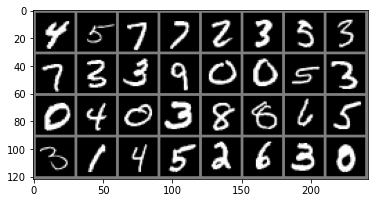

Labels were:
[[4 5 7 7 2 3 5 3]
 [7 3 3 9 0 0 5 3]
 [0 4 0 3 8 8 6 5]
 [3 1 4 5 2 6 3 0]]


In [57]:
def imshow(img, l):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    print('Labels were:')
    print(l.reshape(-1,8).numpy())

# Load sample data
dataiter = iter(trainloader)
images, labels = dataiter.next()
print('shape of images', images.shape)

# display batch
imshow(utils.make_grid(images),labels)

## Loss function for learning.
* NLLLoss: The abbrivation NLL stands for Negetive log likelihood. It is however a bit of misnomer as the log is not included in the loss itself but was part of the network defination above. 
* NOTE: When you want to get the probability/likelihood of an image being of a perticular class you need to remove the log from the forward function and use simple softmax activation at test time. Alternatively simply use ''exp'' function from torch to invert log and leave the forward function as it is. 

## Optimizer
* pytorch have various optimization rutines (beyond SGD) pre-implemented.
* class optim will take care of backpropogation with these different optimizations for learning as long as the network defination with appropriate forward function is written correctly.
* Here we just use SGD. with learning rate 0.001 and momentum 0.9.

In [58]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
if FLAG_GPU:
    criterion = criterion.cuda()

## This cell of the notebook is now training a network.

* First for loop goes throught the entire data 5 times (We run 5 epochs for our training).
* The simple steps for training a NN with pytorch are:
    * Load data in minibatches.
    * Set gradients for all the network parameters to zero (dont forget this)
    * Pass data to the NN using a net.forward() to compute layer by layer output.
        * Intermediate outputs can be returned as extra variables in forward function.
    * Compute the loss from the output (remember it is defined above).
    * Use loss.backword() to compute all the gradients by appropriately applying chain rule! 
        * It actually know how to differentiate things!!!
    * Use optimizer.step() updates weights.
    
## At the end of every epoch usually we check if NN generalizes.
* Generalization is critical in learning.
* We evaluate the performance of our NN on new data, for which the NN loss was not minimized.
* torch.no_grad() command forces the following code to not keep track of the gradients as for testing we dont need them.
* As no gradients are maintained, the code runs faster!
* It a very good practice to make use of no_grad function to ensure that we dont accidently minimize loss on the data we are testing the performance on.


 


In [59]:
if RUN_TRAINING:
    for epoch in range(5):  # loop over the dataset multiple times

        running_loss = 0.0

        # Simply for time keeping
        start_time = time.time()
        # Loop over all training data
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward 
            if FLAG_GPU:
                outputs = net(inputs.cuda())
                loss = criterion(outputs, labels.cuda())
            else:
                outputs = net(inputs)
                loss = criterion(outputs, labels)

            # Compute Gradients
            loss.backward()
            # BackProp
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 100 == 99:    # print every 100 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
            # endif
        # end for over minibatches epoch finishes
        end_time = time.time()

        # test the network every epoch on test example
        correct = 0
        total = 0

        # Test after the epoch finishes (no gradient computation needed)
        with torch.no_grad():
            for data in testloader:
                # load images and labels
                images, labels = data

                if FLAG_GPU:
                    outputs = net(images.cuda())
                    # note here we take the max of all probability
                    _, predicted = torch.max(outputs.cpu(), 1)
                else:
                    outputs = net(images)
                    # note here we take the max of all probability
                    _, predicted = torch.max(outputs, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

          #end for
        #end with
        print('Epoch', epoch+1, 'took', end_time-start_time, 'seconds')
        print('Accuracy of the network after', epoch+1, 'epochs is' , 100*correct/total)

    print('Finished Training')

[1,   100] loss: 2.288
[1,   200] loss: 2.238
[1,   300] loss: 2.088
[1,   400] loss: 1.591
[1,   500] loss: 0.927
[1,   600] loss: 0.602
[1,   700] loss: 0.484
[1,   800] loss: 0.435
[1,   900] loss: 0.367
[1,  1000] loss: 0.332
[1,  1100] loss: 0.321
[1,  1200] loss: 0.260
[1,  1300] loss: 0.257
[1,  1400] loss: 0.264
[1,  1500] loss: 0.234
[1,  1600] loss: 0.201
[1,  1700] loss: 0.195
[1,  1800] loss: 0.194
Epoch 1 took 16.058056354522705 seconds
Accuracy of the network after 1 epochs is 94.99
[2,   100] loss: 0.178
[2,   200] loss: 0.160
[2,   300] loss: 0.145
[2,   400] loss: 0.153
[2,   500] loss: 0.156
[2,   600] loss: 0.141
[2,   700] loss: 0.141
[2,   800] loss: 0.139
[2,   900] loss: 0.157
[2,  1000] loss: 0.147
[2,  1100] loss: 0.114
[2,  1200] loss: 0.128
[2,  1300] loss: 0.133
[2,  1400] loss: 0.104
[2,  1500] loss: 0.123
[2,  1600] loss: 0.103
[2,  1700] loss: 0.111
[2,  1800] loss: 0.112
Epoch 2 took 15.350618124008179 seconds
Accuracy of the network after 2 epochs is 97

# For grading
* Your convolutional network should be called ``net`` (this is already done in the code provided)
* **You will be graded based on the architecture and performance of your network (6 pts max.)**:
    - You will receive a total of 3pts if your architecture is correct.
    - You will receive 1 pt if the accuracy of your network is less than 60%
    - You will receive 2 pts if the accuracy of your network is more than 60%, but less than 95%
    - You will receive 3 pts if the accuracy of your network is above 95%
* <p style="color:#FF0000";> <b>Important: Set the RUN_TRAINING and FLAG_GPU (they are defined in the first cell of this notebook) flags to False before submitting your notebook</b></p> 
* Save your trained network and submit it along witht this notebook (your file should be called ``<STUDENT ID>_ConvNet.pt``. 
* <p style="color:#FF0000";> <b>Important: Do not forget to submit both your notebook and your trained network </b></p>

To save your notebook, please execute the code provided below:

In [61]:
file_name = "{}_ConvNet.pt".format("28958837")
torch.save(net.state_dict(), file_name)

### To test if your network has been saved correctly, you can use the code provided below

In [62]:
# Create a new instance of your conv net
model = ConvNet()

# Load the parameters you saved into the new instance
if FLAG_GPU:
    device = torch.device('cuda')
    model.load_state_dict(torch.load(file_name))
    model.to(device)
else:
    device = torch.device('cpu')
    model.load_state_dict(torch.load(file_name, map_location=device))    

# Set your network in evaluation mode before running inference.
model.eval()

# Run inference with the new instance
# Performance should be the same as observed at the end of the training
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        # load images and labels
        images, labels = data

        if FLAG_GPU:
            outputs = net(images.cuda())
            # note here we take the max of all probability
            _, predicted = torch.max(outputs.cpu(), 1)
        else:
            outputs = net(images)
            # note here we take the max of all probability
            _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network after is' , 100*correct/total)

Accuracy of the network after is 98.23
